In [2]:
import pandas as pd
from math import sqrt, ceil
import os
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
import re
import seaborn as sns
from rich.progress import Progress

Load data and instantiate class for label transfer

In [3]:
datasets = pd.read_csv('datasets.csv')
datasets = datasets[~datasets['study_id'].isin(['Ho2020M', 'Ho2020F'])]

shap_dir = "label_transfer_model_output/shap_top_genes"
predictions_dir = "label_transfer_model_output/predictions"
model_dir = "label_transfer_model_output"
data_dir = "exported_matrices"
random_seed = 12345

if not os.path.exists(shap_dir):
    os.makedirs(shap_dir)
    
if not os.path.exists(predictions_dir):
    os.makedirs(predictions_dir)

## Convenience functions

In [4]:
def load_data(dataset: str, test_size: float = 0.2) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Loads the data for a single dataset.

    Parameters
    ----------

    dataset : str
        The name of the dataset, e.g. Cheung2018M.
    test_size : float, optional, default = 0.1
        The size of the test set. Defaults to 0.1, i.e. 10% of the data is used for training and 90% for testing.

    Returns
    -------

    (expr_data_train, expr_data_test, labels_data_train, labels_data_test) : tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]
        The expression data and labels for the training and test sets.
    """
    expr_data = pd.read_csv(os.path.join(
        data_dir, f"{dataset}_expression.csv"), index_col=0)
    expr_data = expr_data.T

    labels_data = pd.read_csv(os.path.join(
        data_dir, f"{dataset}_clusters.csv"), index_col=0)
    labels_data = labels_data['Cluster'].values

    expr_data_train, expr_data_test, labels_data_train, labels_data_test = train_test_split(
        expr_data, labels_data, train_size=1.0-test_size, random_state=random_seed)

    return (expr_data_train, expr_data_test, labels_data_train, labels_data_test)


def get_hyperparameters(dataset: str) -> dict:
    """
    Returns the model hyperparameters for a given dataset.

    Parameters
    ----------
    dataset: str
        The name of the dataset.

    Returns
    -------
    hyperparameters : dict
        The hyperparameters for the given dataset.        
    """

    hyperparams = pd.read_csv('hyperparams.csv')

    assert (
        dataset in hyperparams['dataset'].values), f"Dataset {dataset} not found. Possible values are {hyperparams['dataset'].values}"

    return hyperparams[hyperparams['dataset'] == dataset].to_dict(orient='records')[0]


def find_best_model(dataset: str) -> str | None:
    """
    Finds the best model for a given dataset.

    Parameters
    ----------
    dataset: str
        The name of the dataset.

    Returns
    -------
    best_model : str | None
        The name of the best model, or None if no models are found.
    """

    all_models = [f for f in os.listdir(model_dir) if (
        f.endswith('.json') and "_f1_" in f)]

    pattern = re.compile(r'^(.+?)(M|F)_(\d{8}-\d{6})_f1_(\d+\.\d+)\.json$')

    # Extract studynames
    studies = []
    dates = []
    f1s = []

    for filename in all_models:
        if match := pattern.match(filename):
            studies.append(match[1] + match[2])
            dates.append(match[3])
            f1s.append((match[4]))

    df = pd.DataFrame({'study': studies, 'date': dates, 'f1': f1s})    
    df = df[df['study'] == dataset]
    if len(df) == 0:
        return None

    df = df.sort_values(by='f1', ascending=False)

    return f"{df.iloc[0]['study']}_{df.iloc[0]['date']}_f1_{df.iloc[0]['f1']}.json"


def evaluate_model(model: xgb.XGBClassifier, expr_test: np.ndarray, cluster_test: np.ndarray, num_classes: int) -> tuple[np.ndarray, np.ndarray, dict]:
    """
    Evaluates a model on a test set.

    Parameters
    ----------

    model : xgb.XGBClassifier
        The fitted model to evaluate.
    expr_test : np.ndarray
        The expression data for the test set.
    cluster_test : np.ndarray
        The true labels for the test set.
    num_classes : int
        The number of classes in the dataset.

    Returns
    -------

    (predictions, probabilities, metrics) : tuple[np.ndarray, np.ndarray, dict]
        The predictions, probabilities, and evaluation metrics for the model.        
    """

    # Evaluate the model
    predictions = model.predict(expr_test)
    probabilities = model.predict_proba(expr_test)

    # Binarize the output
    y_test_binarized = label_binarize(
        cluster_test, classes=np.arange(num_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    threshold = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(
            y_test_binarized[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], threshold["micro"] = roc_curve(
        y_test_binarized.ravel(), probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # Compute macro-average ROC curve and ROC area
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)

    return (predictions, probabilities, {
        'confusion_matrix': confusion_matrix(cluster_test, predictions),
        'f1_score': f1_score(cluster_test, predictions, average='macro'),
        'fpr': fpr,
        'tpr': tpr,
        'threshold': threshold,
        'roc_auc': roc_auc,
        'macro_auc': macro_auc,
        'all_fpr': all_fpr,
        'mean_tpr': mean_tpr
    })

### Predict all datasets

In [5]:
model_files = {id: find_best_model(id) for id in set(datasets['study_id'])}
models = {}
predictions = {}
with Progress() as progress:
    from_task = progress.add_task("[cyan]Loading models...", total=len(model_files))
    to_task = progress.add_task(f"[purple]Predicting...", total=len(set(datasets['study_id']))-1)
    
    for study_id in model_files.keys():
        progress.update(from_task, description=f"[cyan]Using model for {study_id}...")
        models[study_id] = xgb.XGBClassifier()
        models[study_id].load_model(os.path.join(model_dir, model_files[study_id]))
        
        progress.update(from_task, advance=1)
        progress.update(to_task, description=f"[purple]Predicting...")        
        progress.update(to_task, completed=0)
        for study_to_predict in set(datasets['study_id']):
            progress.update(to_task, description=f"[purple]Predicting {study_to_predict}...")
            if study_id == study_to_predict:
                continue
            else:
                expr_train, expr_test, cluster_train, cluster_test = load_data(study_to_predict)
                all_data = pd.concat([expr_train, expr_test])
                predictions[f"{study_to_predict}_predicted_by_{study_id}"] = models[study_id].predict(all_data)    
            
            progress.update(to_task, advance=1)
            

Output()

Save the predictions

In [ ]:
for dataset_to in set(datasets['study_id']):
    sex = 'M' if dataset_to.endswith('M') else 'F'
    seurat_clusters = pd.read_csv(os.path.join(data_dir, f"{dataset_to}_clusters.csv"), index_col=0)
    seurat_clusters = seurat_clusters[['Cluster']]
    seurat_clusters.reset_index(inplace=True)
    seurat_clusters.columns = ['Cell', 'Seurat_cluster']
    predictions_df = seurat_clusters.copy()
    expr_train, expr_test, cluster_train, cluster_test = load_data(dataset_to)
    for dataset_from in set(datasets['study_id']):        
        if dataset_from == dataset_to:
            continue
        if dataset_from.endswith(sex):
            predictions_df[f'Label_Transfer_Cluster_{dataset_from}'] = predictions[f"{dataset_to}_predicted_by_{dataset_from}"]
    
    predictions_df.to_csv(os.path.join(predictions_dir, f"{dataset_to}_label_transfer_predictions.csv"), index=False)

Plot predictions on UMAP

In [1]:
def plot_predictions(dataset:str)->None:
    """
    Plots the predictions for a given dataset.

    Parameters
    ----------
    dataset: str
        The name of the dataset.
    """
    
    key_names = [p for p in predictions.keys() if p.startswith(dataset)]
    
    umap = pd.read_csv(os.path.join(data_dir, f"{dataset}_umap.csv"), index_col=0)
    seurat_clusters = pd.read_csv(os.path.join(data_dir, f"{dataset}_clusters.csv"), index_col=0)
    seurat_clusters = seurat_clusters[['Cluster']]
    
    num_plots = len(key_names)
    fig, ax = plt.subplots(ceil(sqrt(num_plots)), ceil(sqrt(num_plots)), figsize=(20, 20))
    for k in key_names:
        pred = predictions[k]
        

NameError: name 'predictions' is not defined

### Calculate SHAP values for all datasets/clusters

Loaded data for Kucka2021F.
Train: 1966
Test: 492
Calculating SHAP values for Kucka2021F


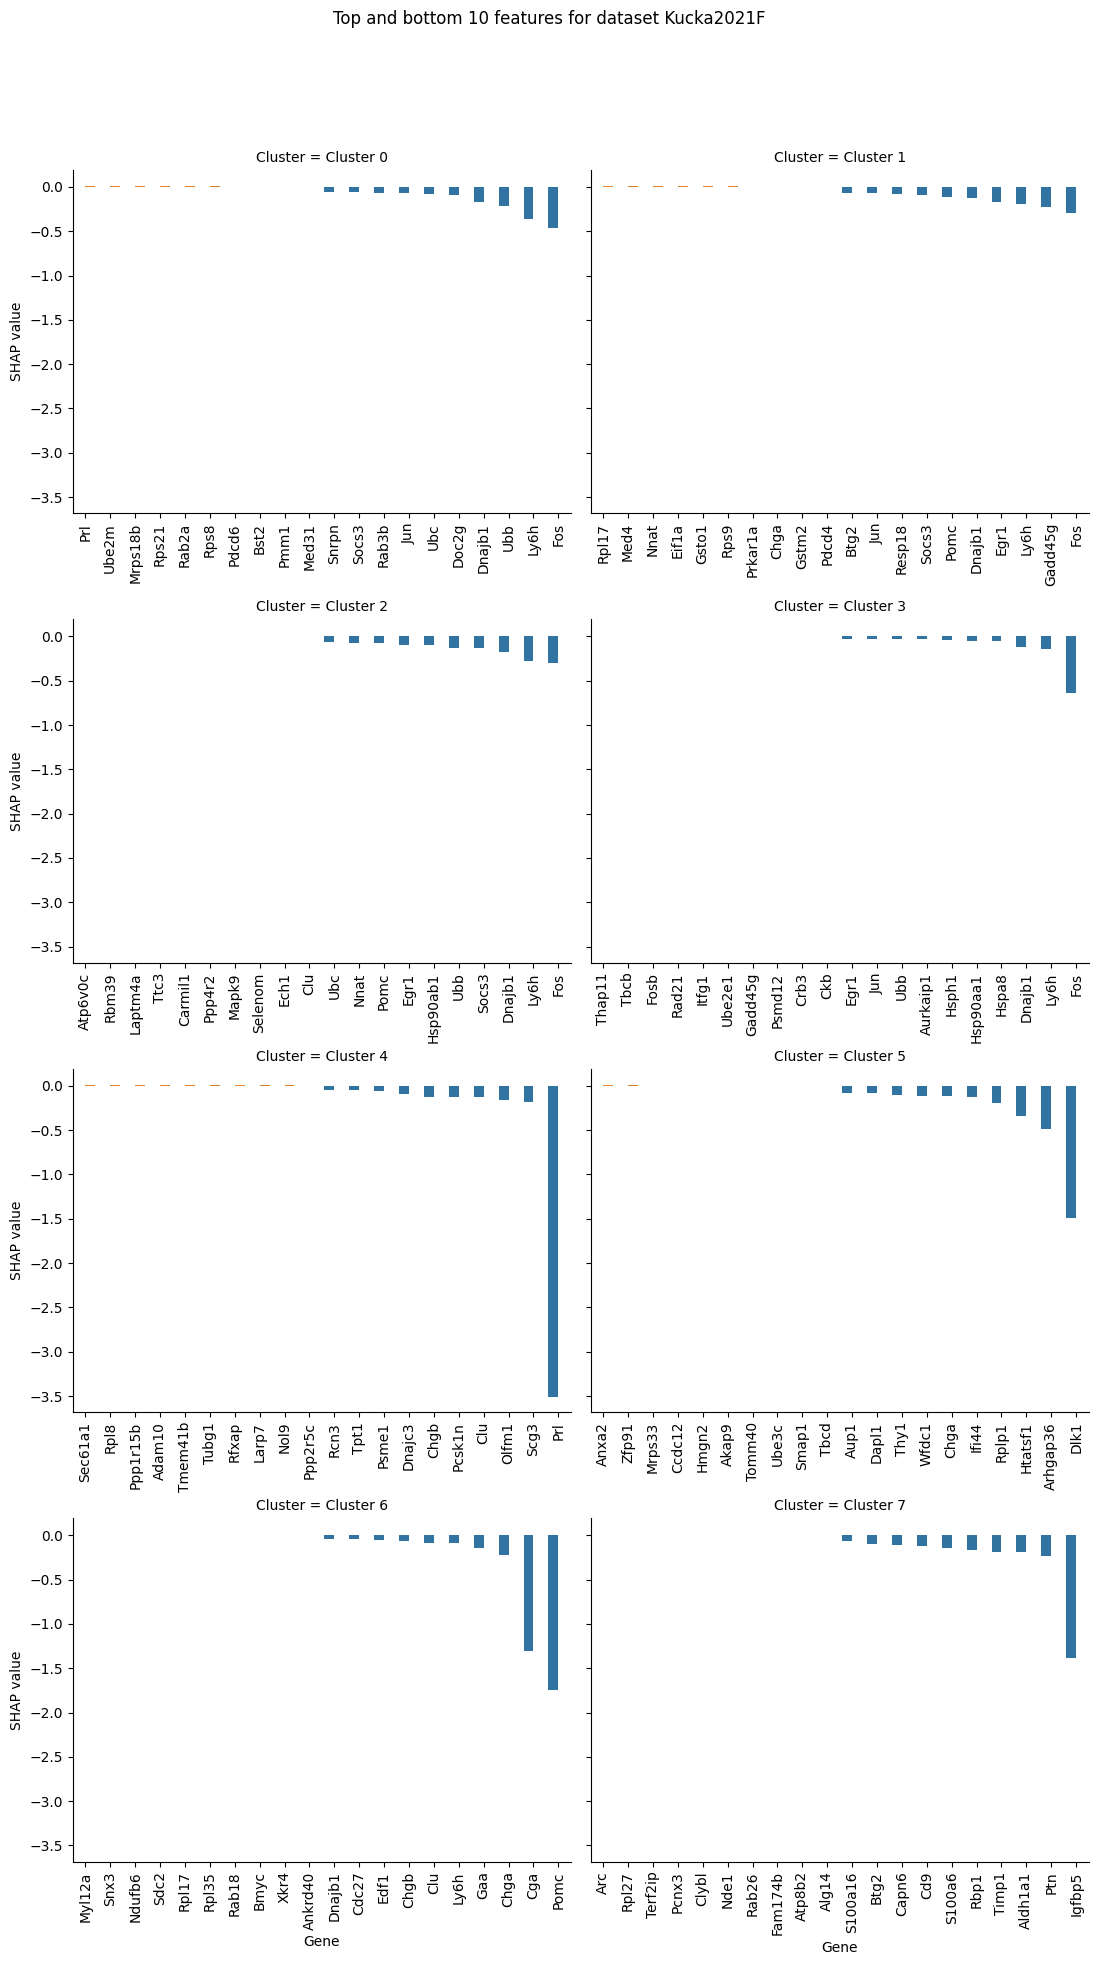

Loaded data for Cheung2018M.
Train: 775
Test: 194
Calculating SHAP values for Cheung2018M


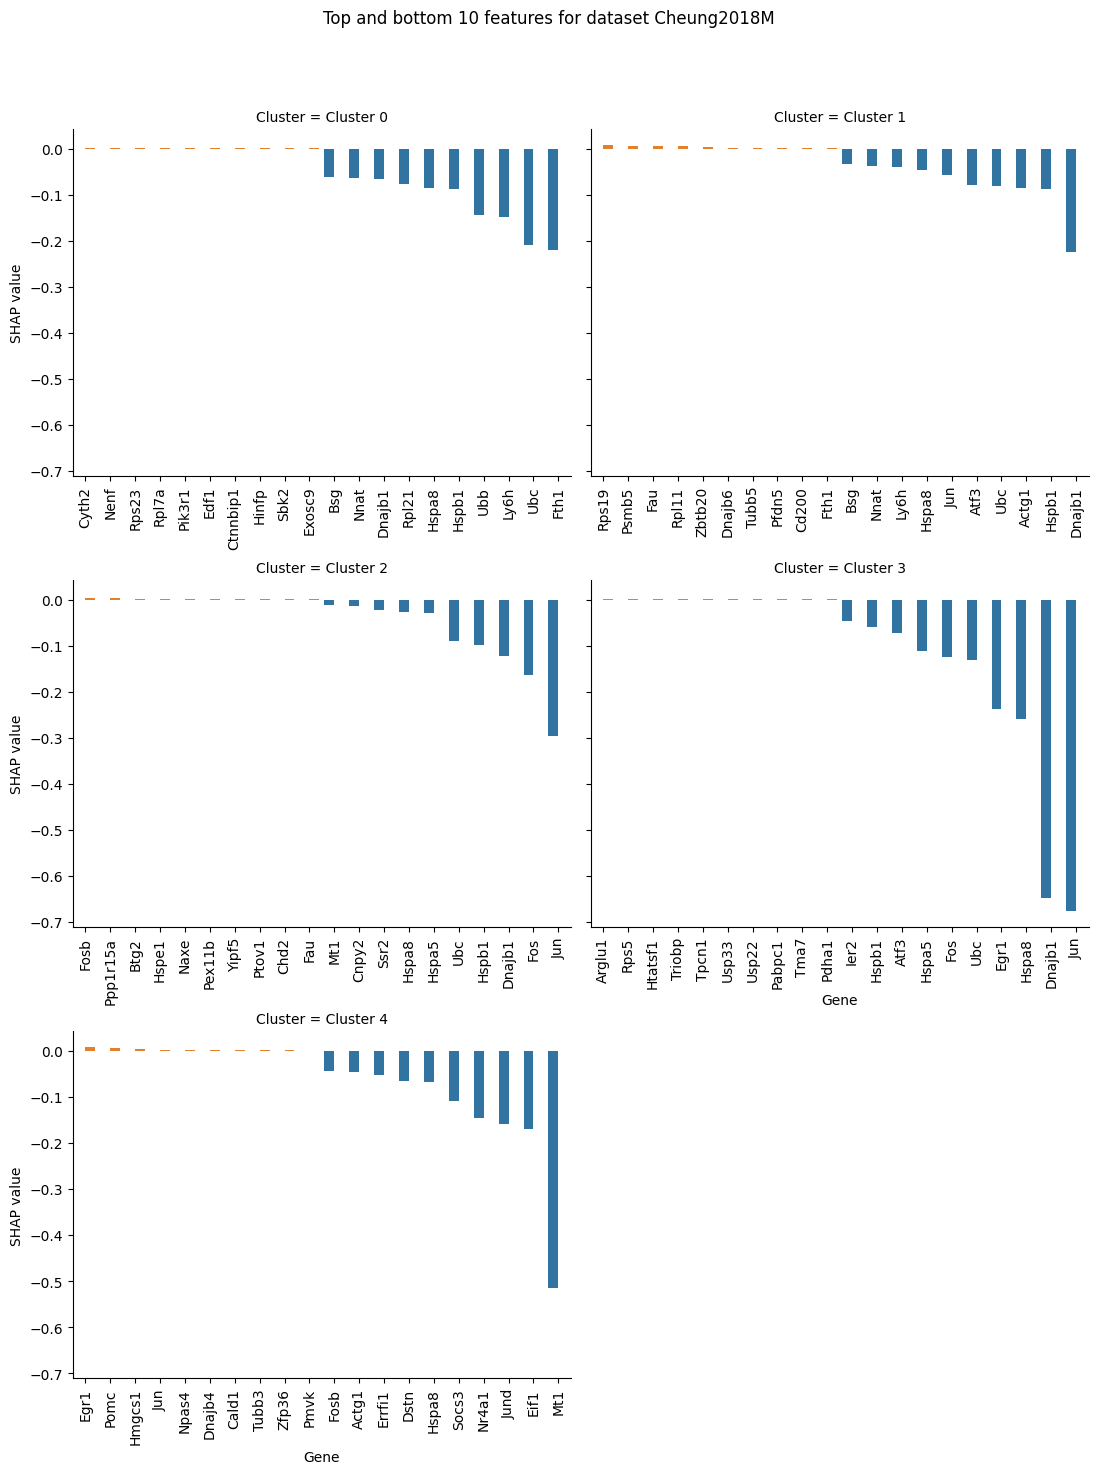

Loaded data for Ruf_Zamojski2021M.
Train: 2173
Test: 544
Calculating SHAP values for Ruf_Zamojski2021M


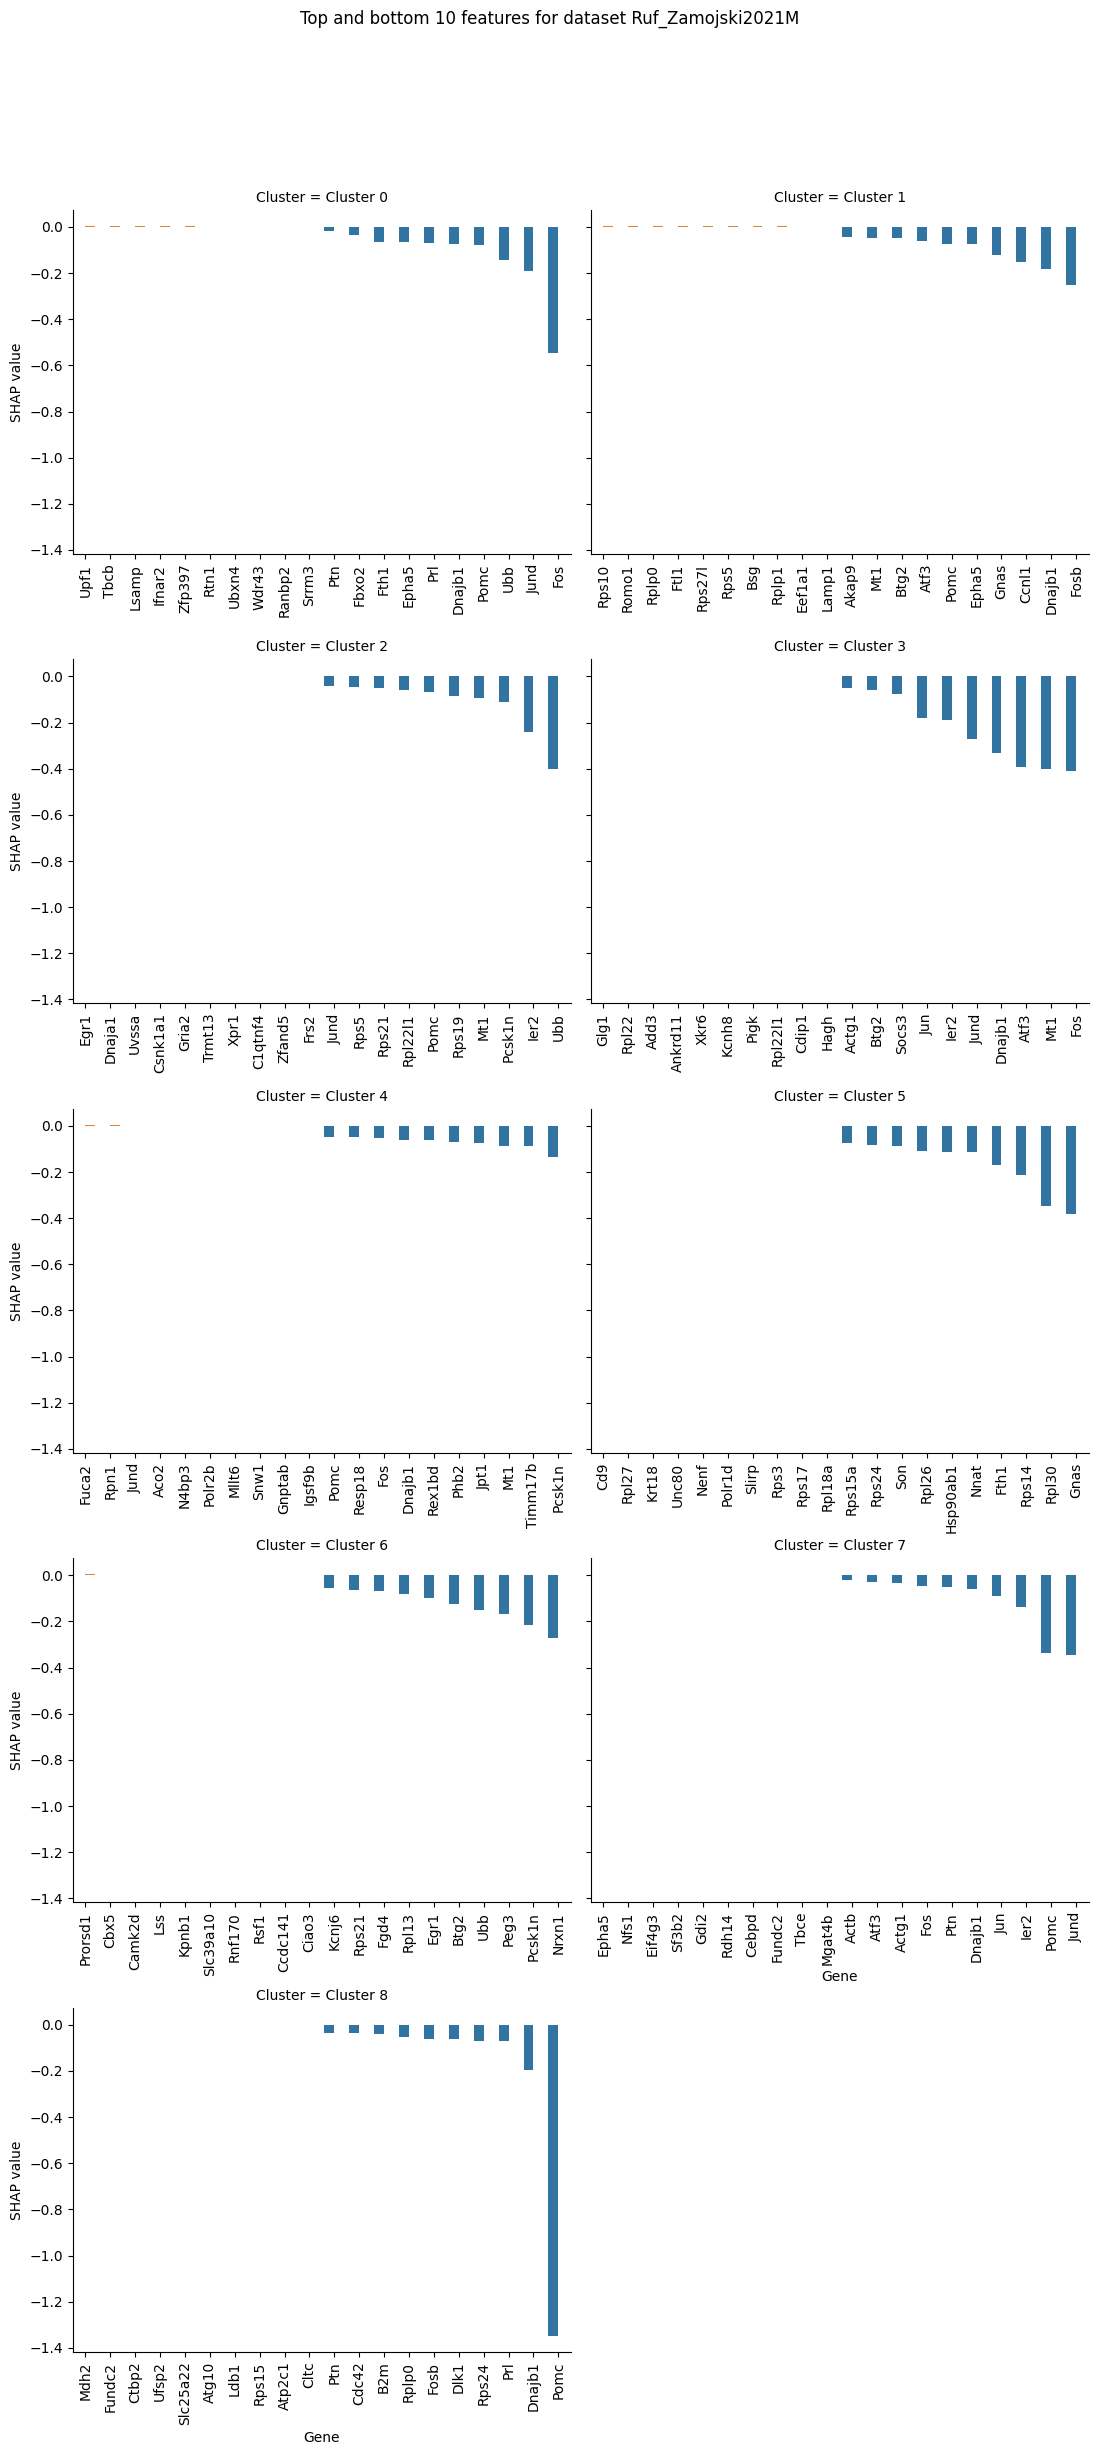

Loaded data for Vennekens2021M.
Train: 433
Test: 109
Calculating SHAP values for Vennekens2021M


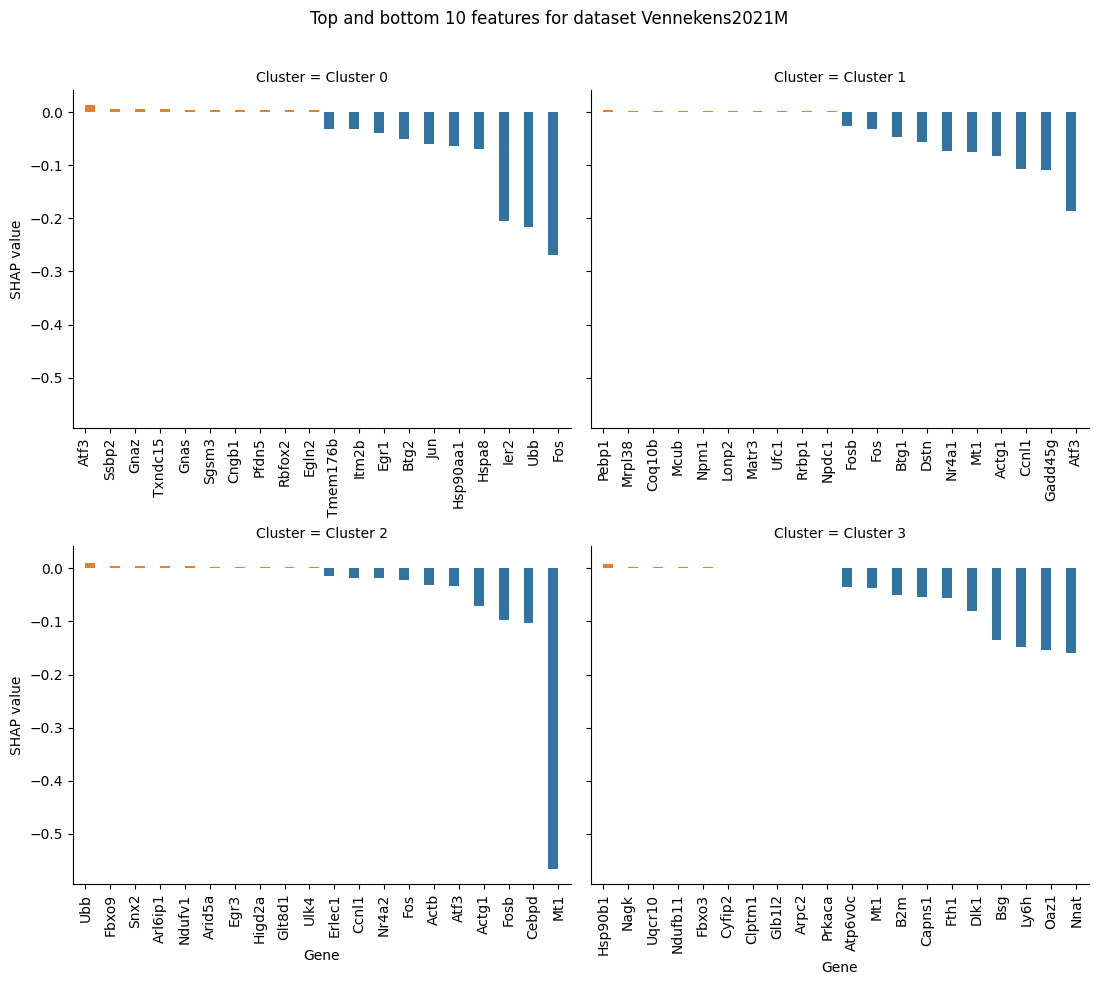

Loaded data for Fletcher2019M.
Train: 877
Test: 220
Calculating SHAP values for Fletcher2019M


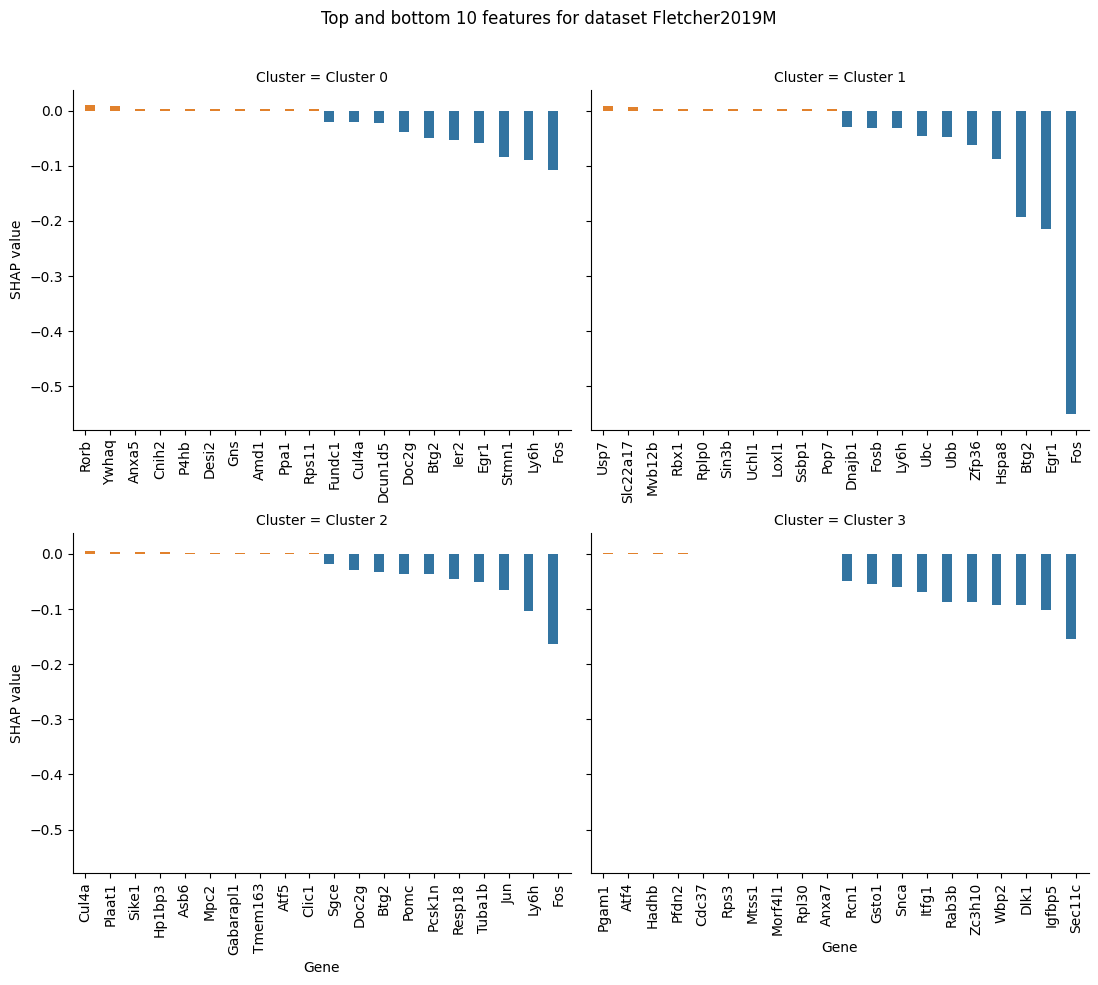

Loaded data for Lopez2021M.
Train: 283
Test: 71
Calculating SHAP values for Lopez2021M


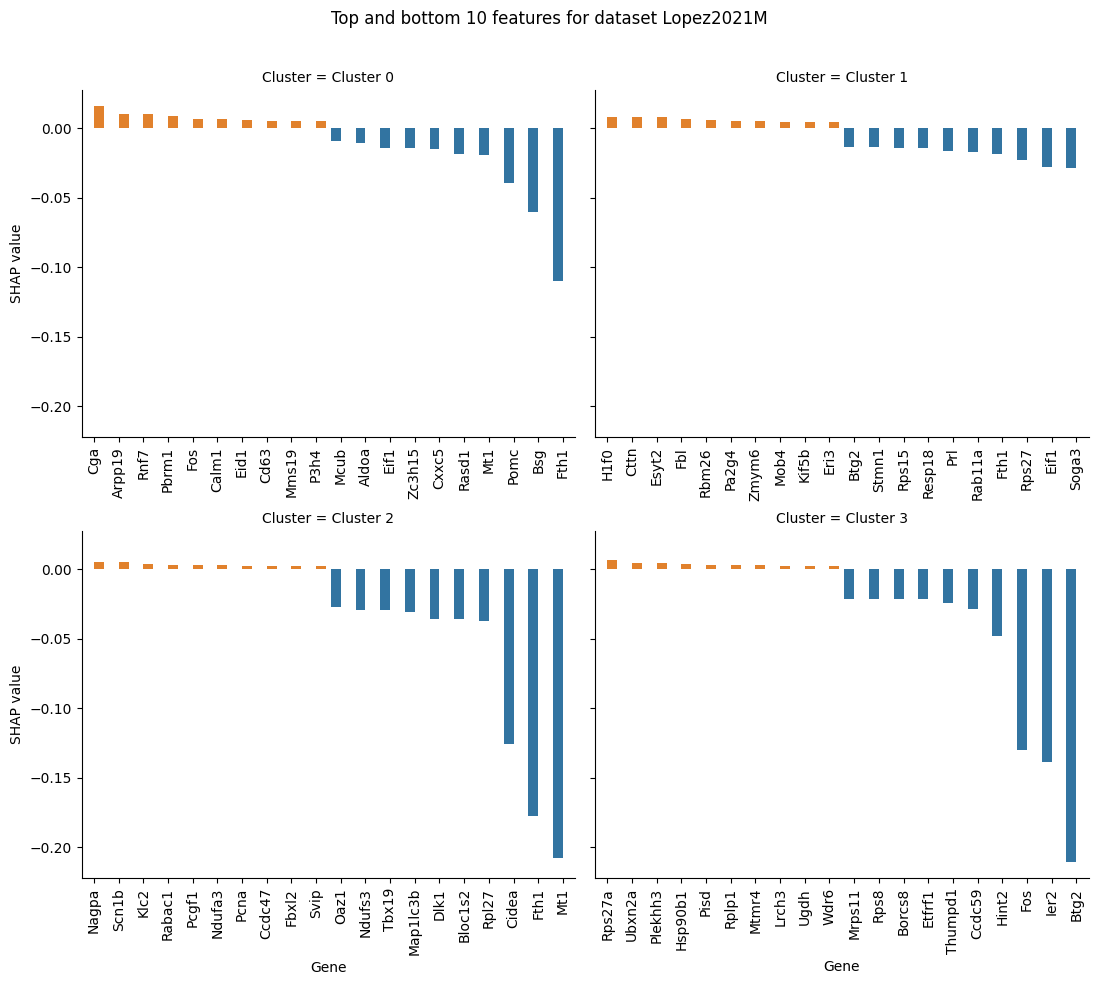

Loaded data for Mayran2019M.
Train: 763
Test: 191
Calculating SHAP values for Mayran2019M


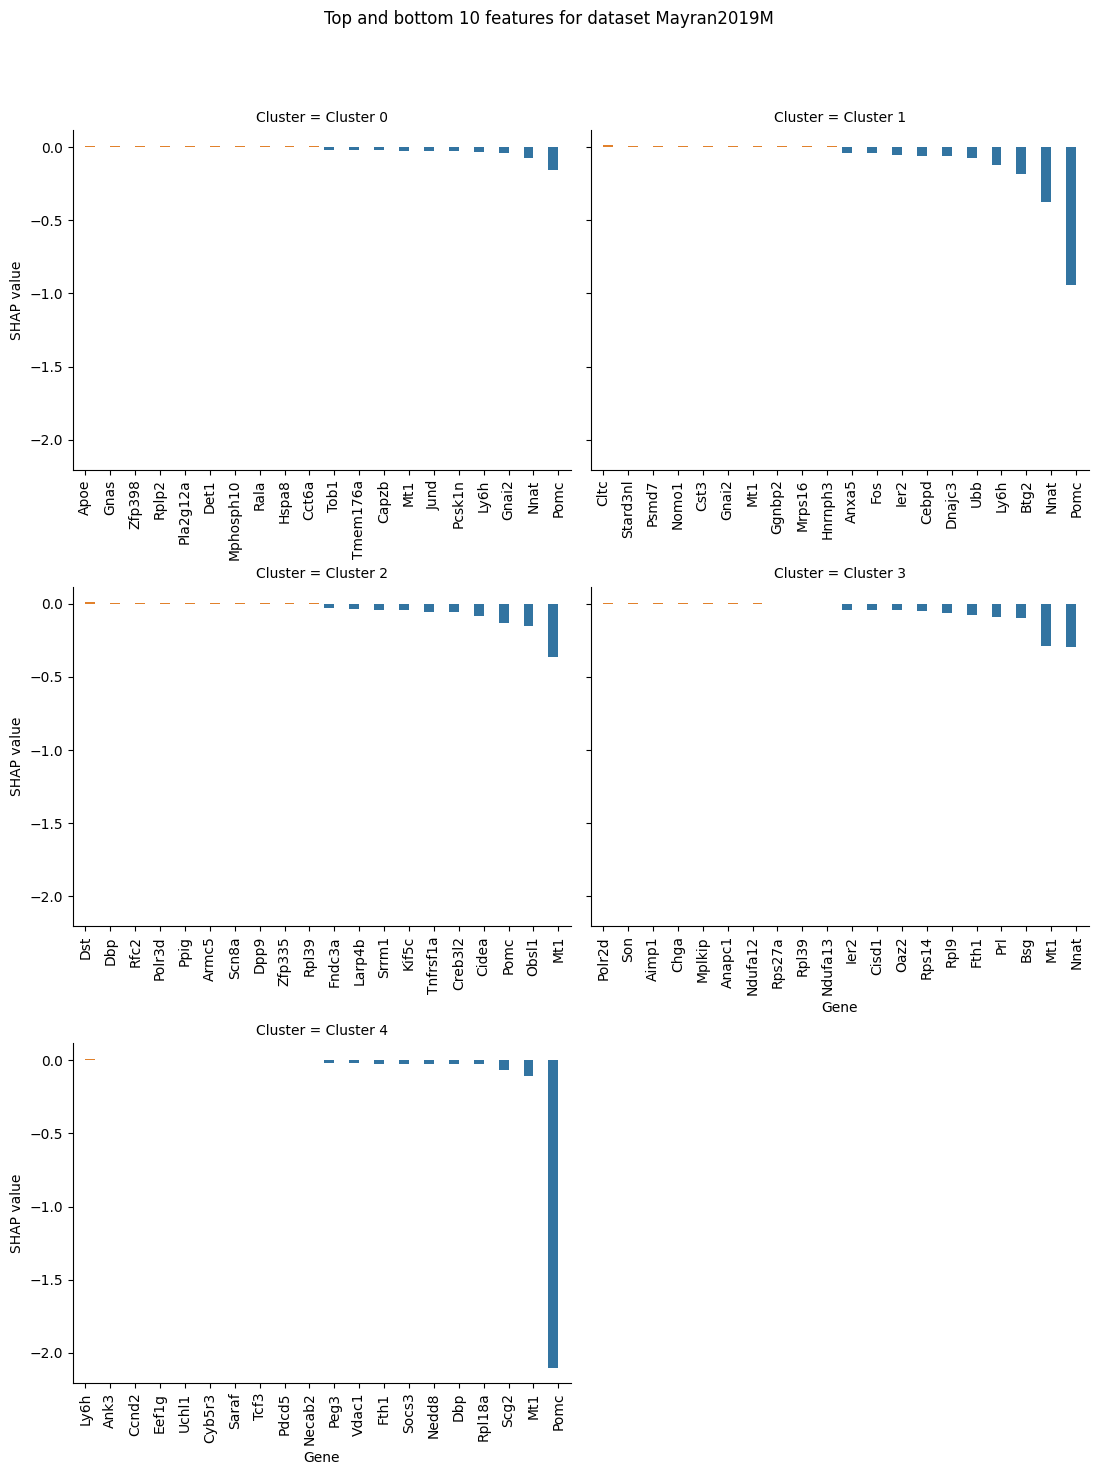

Loaded data for Ruf_Zamojski2021F.
Train: 2030
Test: 508
Calculating SHAP values for Ruf_Zamojski2021F


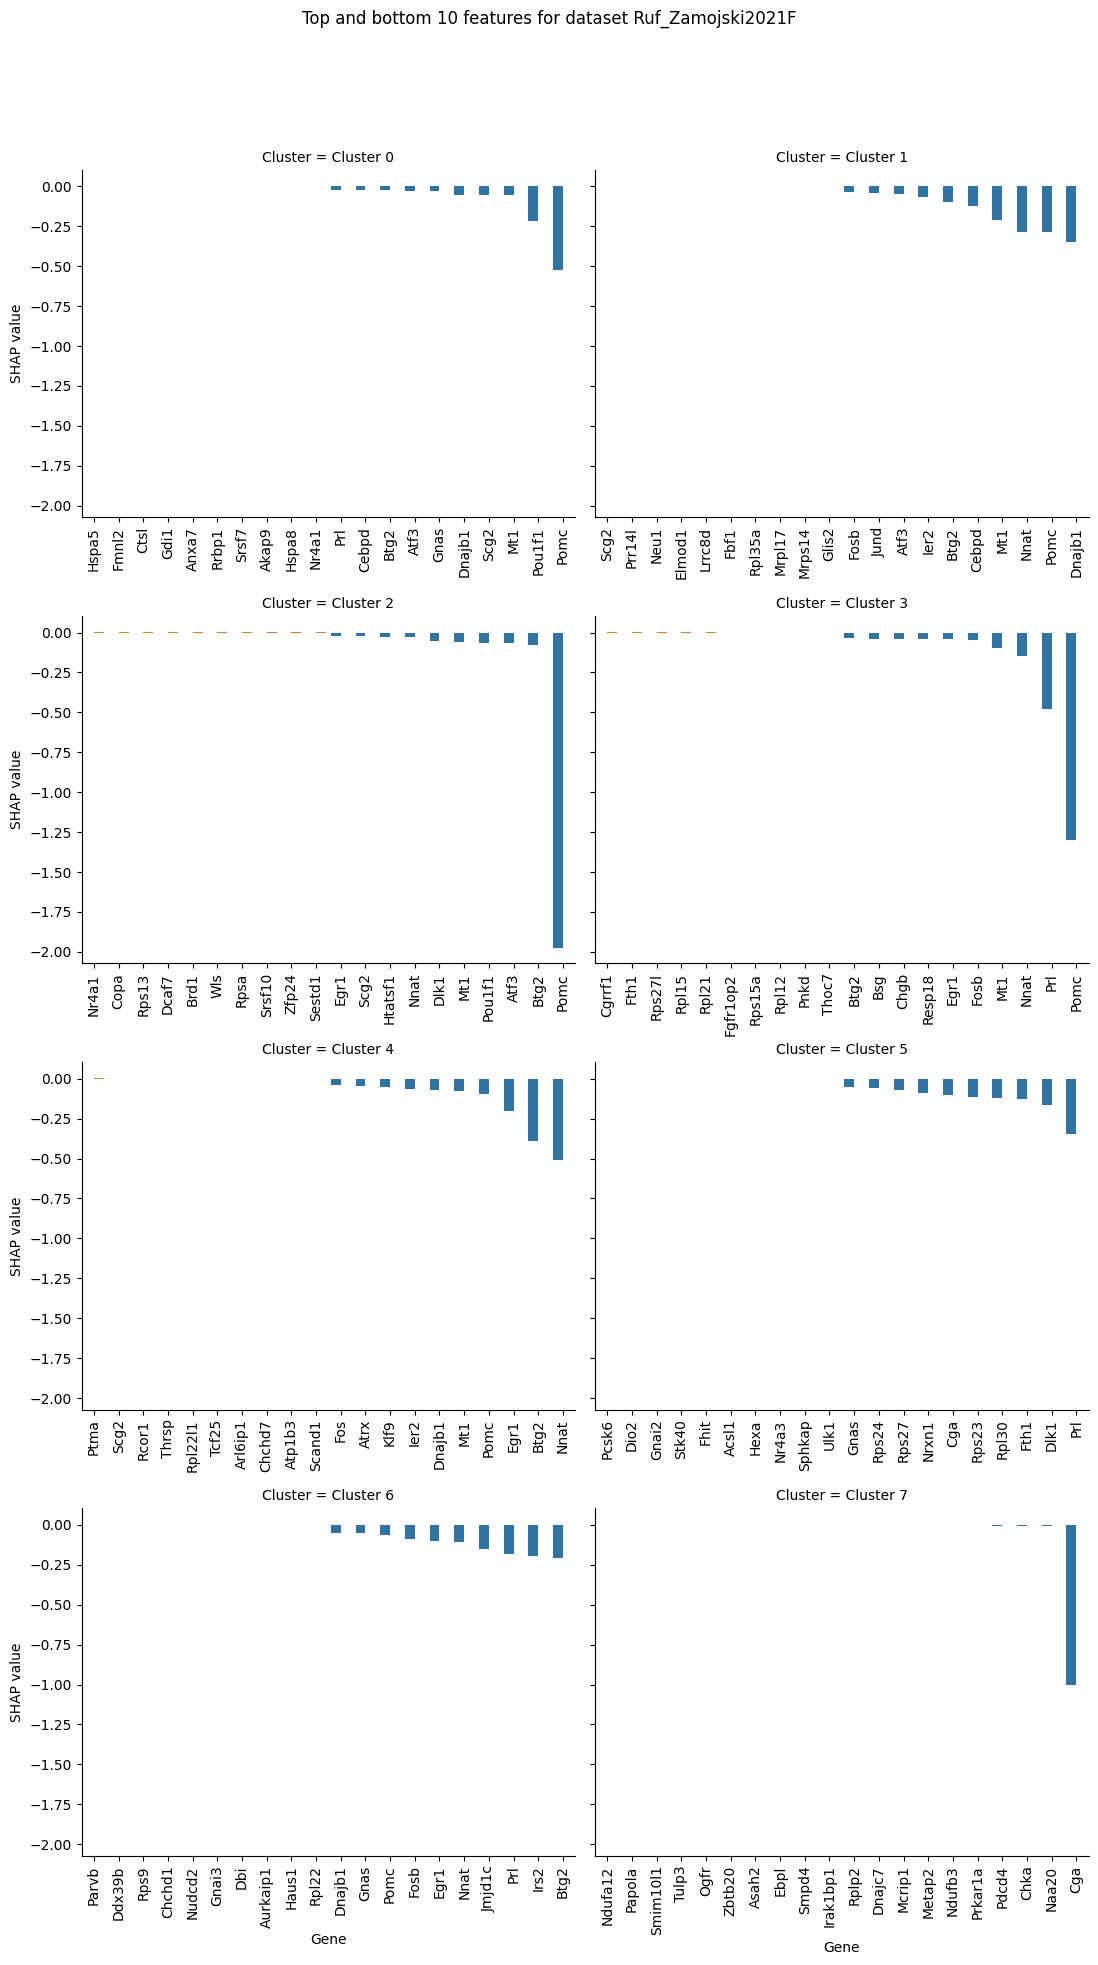

Loaded data for Fletcher2019F.
Train: 628
Test: 157
Calculating SHAP values for Fletcher2019F


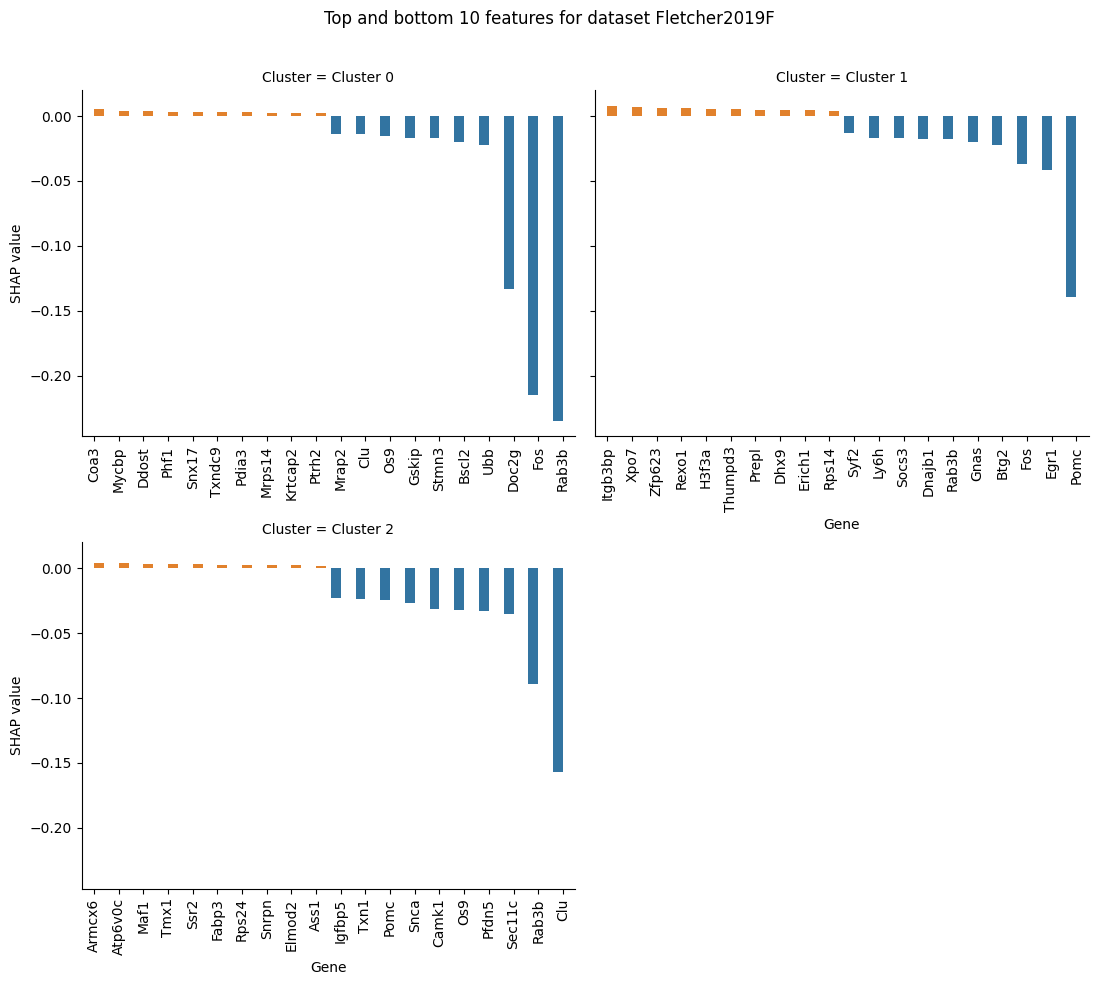

Loaded data for Allensworth2021F.
Train: 1025
Test: 257
Calculating SHAP values for Allensworth2021F


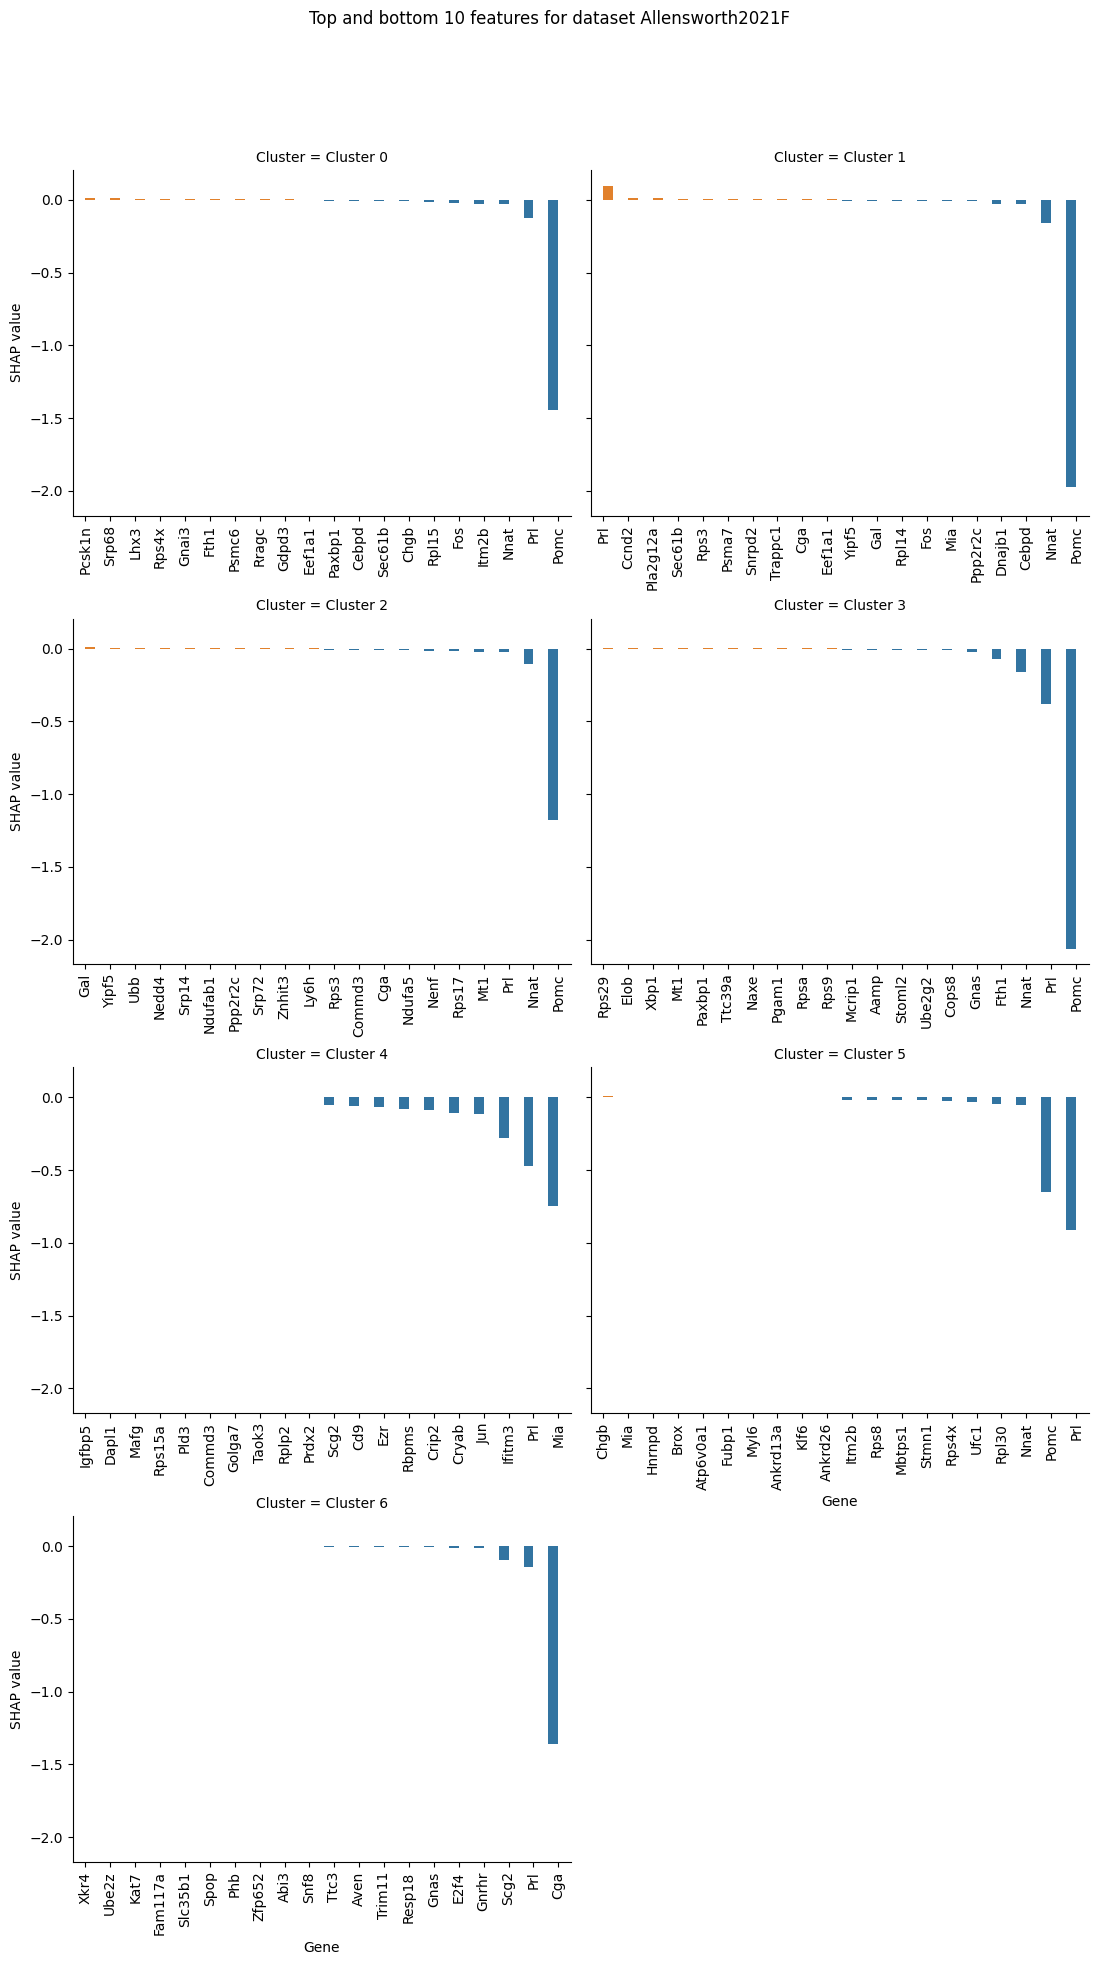

In [6]:
def top_SHAP(dataset: str, mean_shap_per_cluster: pd.DataFrame, save: bool = False, plot: bool = True) -> None:
    """
    Gets the top and bottom 10 SHAP values for each cluster. If requested, saves the values to CSV and/or plots them.
    
    Parameters
    ----------
    dataset : str
        The name of the dataset.
    mean_shap_per_cluster : pd.DataFrame
        The mean SHAP values for each cluster.
    save : bool, optional, default = False
        Whether to save the data to a CSV file.
    plot : bool, optional, default = True
        Whether to plot the data.
    """
    mean_shap_per_cluster_long = mean_shap_per_cluster.reset_index().rename(columns={'index': 'Gene'})
    mean_shap_per_cluster_long = mean_shap_per_cluster_long.melt(id_vars = ['Gene'], var_name = 'Cluster', value_name = 'SHAP value')
    mean_shap_per_cluster_long['Positive_SHAP'] = mean_shap_per_cluster_long['SHAP value'] > 0
    mean_shap_per_cluster_long['Positive_SHAP'] = mean_shap_per_cluster_long['Positive_SHAP'].astype(int)
    mean_shap_per_cluster_long = mean_shap_per_cluster_long.dropna(subset=['SHAP value'])
    mean_shap_per_cluster_long = mean_shap_per_cluster_long.sort_values(by=['Cluster', 'SHAP value'], ascending=[True, False])

    if save:
        mean_shap_per_cluster_long.to_csv(os.path.join(output_dir, f"{dataset}_top_bottom_shap.csv"), index=False)
    if plot:
        p = sns.catplot(data = mean_shap_per_cluster_long, x = 'Gene', y = 'SHAP value', col = 'Cluster', 
                        hue = 'Positive_SHAP', kind = 'bar', col_wrap = 2, sharex=False)

        for ax in p.axes.flat:
            for label in ax.get_xticklabels():
                label.set_rotation(90)
            
        p.figure.suptitle(f'Top and bottom 10 features for dataset {dataset}')
        p.figure.tight_layout()
        p.figure.subplots_adjust(top=0.9) 

        p._legend.remove()

        plt.show()

for dataset in set(datasets['study_id']):
    hp = get_hyperparameters(dataset)

    features = models[dataset].get_booster().feature_names

    _, expr_test, _, cluster_test = load_data(dataset)
    print(f"Calculating SHAP values for {dataset}")
    explainer = shap.Explainer(models[dataset])
    shap_values = explainer(expr_test)
    mean_shap_per_cluster = pd.DataFrame()
    for cluster in range(hp['num_classes']):
        # Get the mean SHAP values for each feature, sorted by importance
        sorted_shap = pd.DataFrame(shap_values.values[:,:,cluster], columns = features).mean().sort_values(ascending=False)
        # Get the top and bottom 10 features
        top_and_bottom = pd.concat([sorted_shap.head(10), sorted_shap.tail(10)])
        top_and_bottom.name = f"Cluster {cluster}"
        mean_shap_per_cluster = pd.concat([mean_shap_per_cluster, top_and_bottom], axis=1)
    top_SHAP(dataset, mean_shap_per_cluster, save = True, plot = True)        

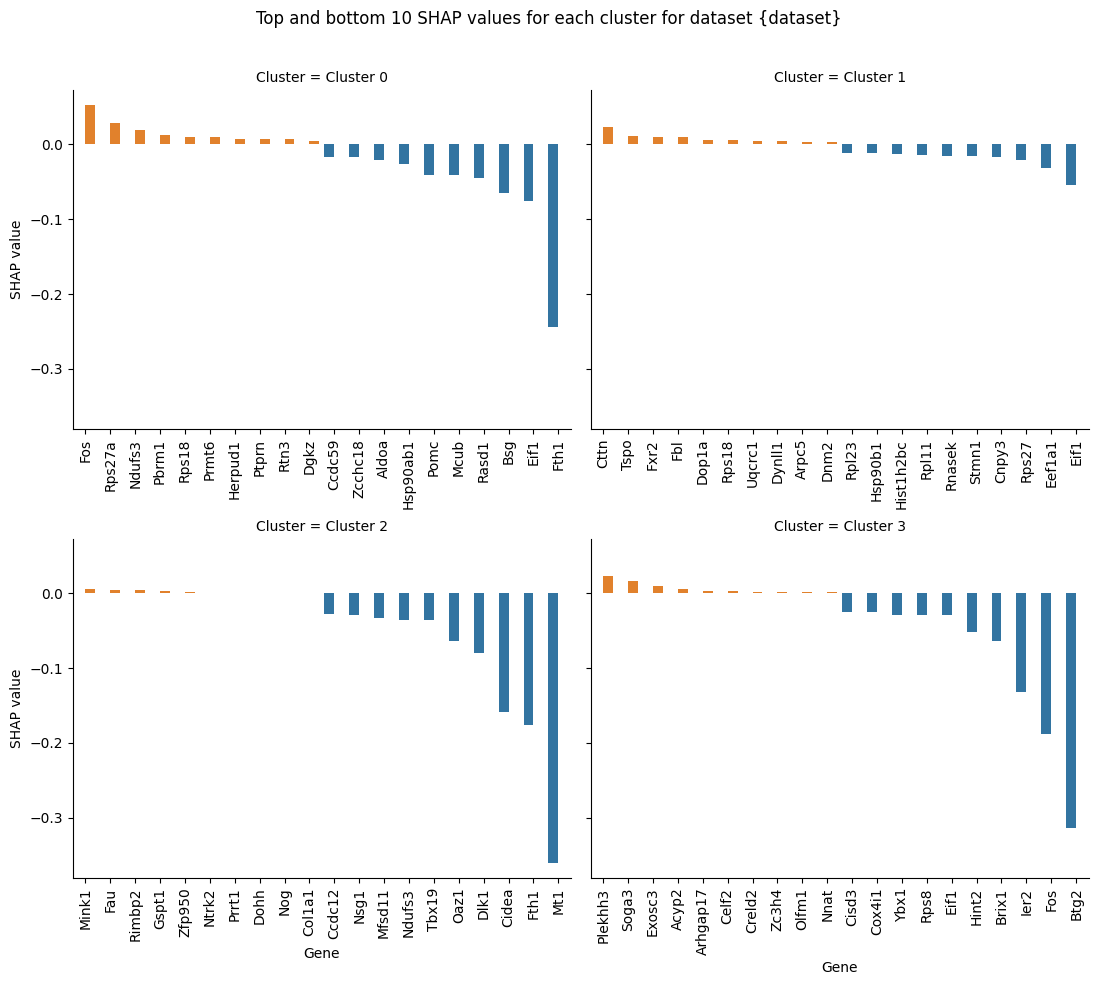

In [46]:
mean_shap_per_cluster_long = mean_shap_per_cluster.reset_index().rename(columns={'index': 'Gene'})
mean_shap_per_cluster_long = mean_shap_per_cluster_long.melt(id_vars = ['Gene'], var_name = 'Cluster', value_name = 'SHAP value')
mean_shap_per_cluster_long['Positive_SHAP'] = mean_shap_per_cluster_long['SHAP value'] > 0
mean_shap_per_cluster_long['Positive_SHAP'] = mean_shap_per_cluster_long['Positive_SHAP'].astype(int)
mean_shap_per_cluster_long = mean_shap_per_cluster_long.dropna(subset=['SHAP value'])
mean_shap_per_cluster_long = mean_shap_per_cluster_long.sort_values(by=['Cluster', 'SHAP value'], ascending=[True, False])

p = sns.catplot(data = mean_shap_per_cluster_long, x = 'Gene', y = 'SHAP value', col = 'Cluster', hue = 'Positive_SHAP', kind = 'bar', col_wrap = 2,
            sharex=False)

for ax in p.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
       
p.figure.suptitle('Top and bottom 10 SHAP values for each cluster for dataset {dataset}')
p.figure.tight_layout()
p.figure.subplots_adjust(top=0.9) 

p._legend.remove()

plt.show()

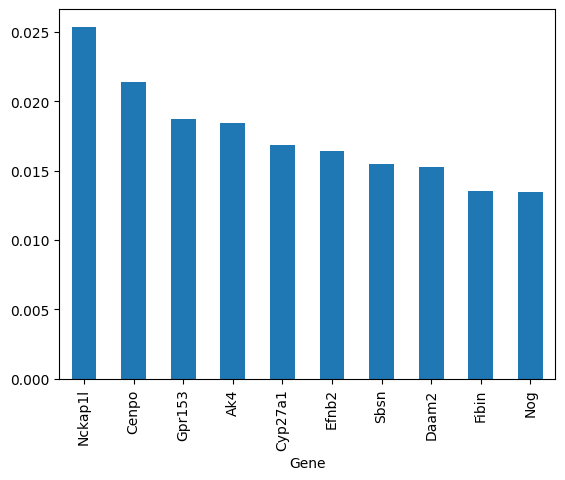

In [29]:
def plot_saliency_bars(dataset:str, cluster:int, n_genes:int = 10, where:str = "top") -> None:
    """
    Plot the saliency of the top n_genes genes for a given cluster in a given dataset.
    
    Parameters
    ----------
    
    dataset: str, cluster:int
        The dataset and cluster to plot the saliency for.
    n_genes: int
        The number of genes to plot.
    where: str
        One of "top", "bottom" or "both". Whether to plot the top, bottom or both top and bottom n_genes (in total).    
    """
    
    if where == "top":
        saliency[dataset][cluster].sort_values(by="Saliency_mean", ascending=False).head(n_genes)['Saliency_mean'].plot.bar()
    elif where == "bottom":
        saliency[dataset][cluster].sort_values(by="Saliency_mean", ascending=True).head(n_genes)['Saliency_mean'].plot.bar()
    elif where == "both":
        saliency[dataset][cluster].sort_values(by='Saliency_mean', ascending=False, key=abs).head(n_genes)["Saliency_mean"].sort_values(ascending = False).plot.bar()
    
plot_saliency_bars("Cheung2018M", 0, 10, "top")

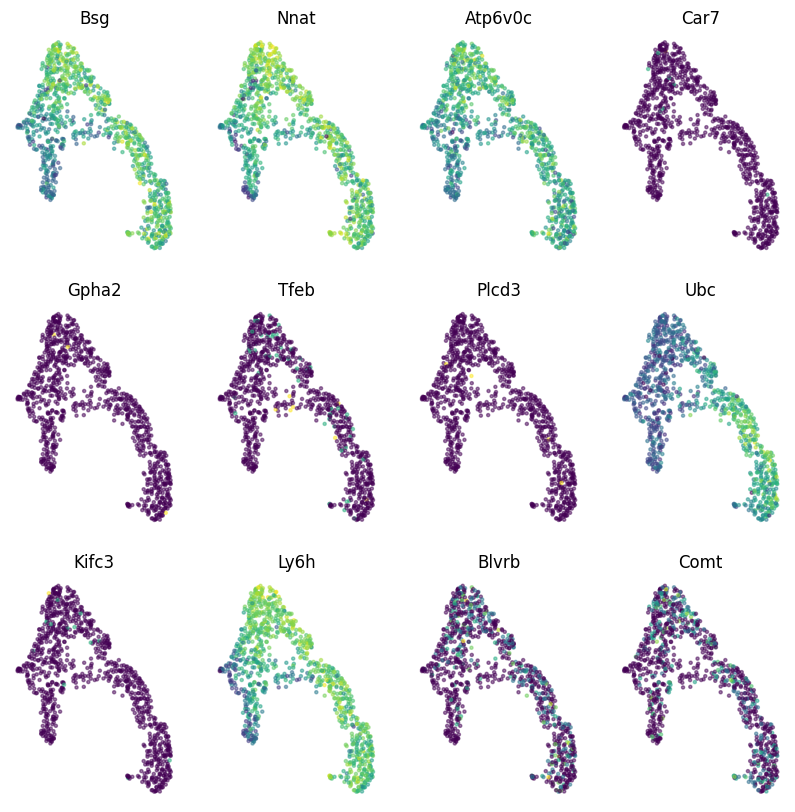

In [62]:
def plot_saliency_on_umap(dataset: str, cluster: int, n_genes: int = 10, where: str = "top") -> None:
    """
    Plot the saliency of the top n_genes genes for a given cluster in a given dataset on the UMAP.

    Parameters
    ----------

    dataset: str, cluster:int
        The dataset and cluster to plot the saliency for.
    n_genes: int
        The number of genes to plot.
    where: str
        One of "top", "bottom" or "both". Whether to plot the top, bottom or both top and bottom n_genes (in total).    
    """

    umap = predictor.umaps[dataset]
    expr = predictor.expression_data[dataset]

    genes = []

    if where == "top":
        genes = saliency[dataset][cluster].sort_values(
            by="Saliency_mean", ascending=False).head(n_genes).index
    elif where == "bottom":
        genes = saliency[dataset][cluster].sort_values(
            by="Saliency_mean", ascending=True).head(n_genes).index
    elif where == "both":
        genes = saliency[dataset][cluster].sort_values(by='Saliency_mean', ascending=False, key=abs).head(
            n_genes)["Saliency_mean"].sort_values(ascending=False).index

    n_row = int(sqrt(n_genes))
    n_col = ceil(n_genes / n_row)    
    
    fig, ax = plt.subplots(n_row, n_col, figsize=(10, 10))
    
    for i, g in enumerate(genes):
        a = ax.ravel()[i]
        a.scatter(umap["UMAP_1"], umap["UMAP_2"], c=expr[g], cmap="viridis", s=5, alpha=0.5)
        a.set_title(g)
        
    for a in ax.ravel():
        a.axis("off")

plot_saliency_on_umap("Cheung2018M", 0, 12, "bottom")